In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install music21
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 58.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.4 MB/s eta 0:00:00
/kaggle/input/classical-music-midi/brahms/br_im2.mid
/kaggle/input/classical-music-midi/brahms/br_im5.mid
/kaggle/input/classical-music-midi/brahms/BR_IM6.MID
/kaggle/input/classical-music-midi/brahms/brahms_opus1_4.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus117_2.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus1_2.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus1_1.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus1_3.mid
/kaggle/input/classical-music-midi/brahms/br_rhap.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus117_1.mid
/kaggle/input/classical-music-midi/granados/gra_esp_4.mid
/kaggle/input/classical-music-midi/granados/gra_esp_2.mid
/kaggle/input/classical-music-midi/granados/gra_esp_

In [2]:
!apt-get update
!pip install music21
!apt-get -y install lilypond
!pip install fluidsynth
!pip install pretty_midi
!pip install --upgrade pyfluidsynth

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]
Get:3 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]       
Get:4 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:7 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [20.3 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1427 kB]
Get:10 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [617 kB]
Hit:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease              
Get:12 http://security.ubuntu.com/ubuntu focal-security/multiverse 

In [3]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

2024-03-18 02:38:59.160272: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 02:38:59.160365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 02:38:59.299533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

keras==3.0.5
matplotlib==3.7.5
music21==9.1.0
numpy==1.26.4
pandas==2.1.4
seaborn==0.12.2
tensorflow==2.15.0


dict_keys(['brahms', 'granados', 'debussy', 'tschai', 'muss', 'haydn', 'balakir', 'bach', 'beeth', 'grieg', 'mozart', 'borodin', 'schubert', 'burgm', 'schumann', 'albeniz', 'mendelssohn', 'chopin', 'liszt'])


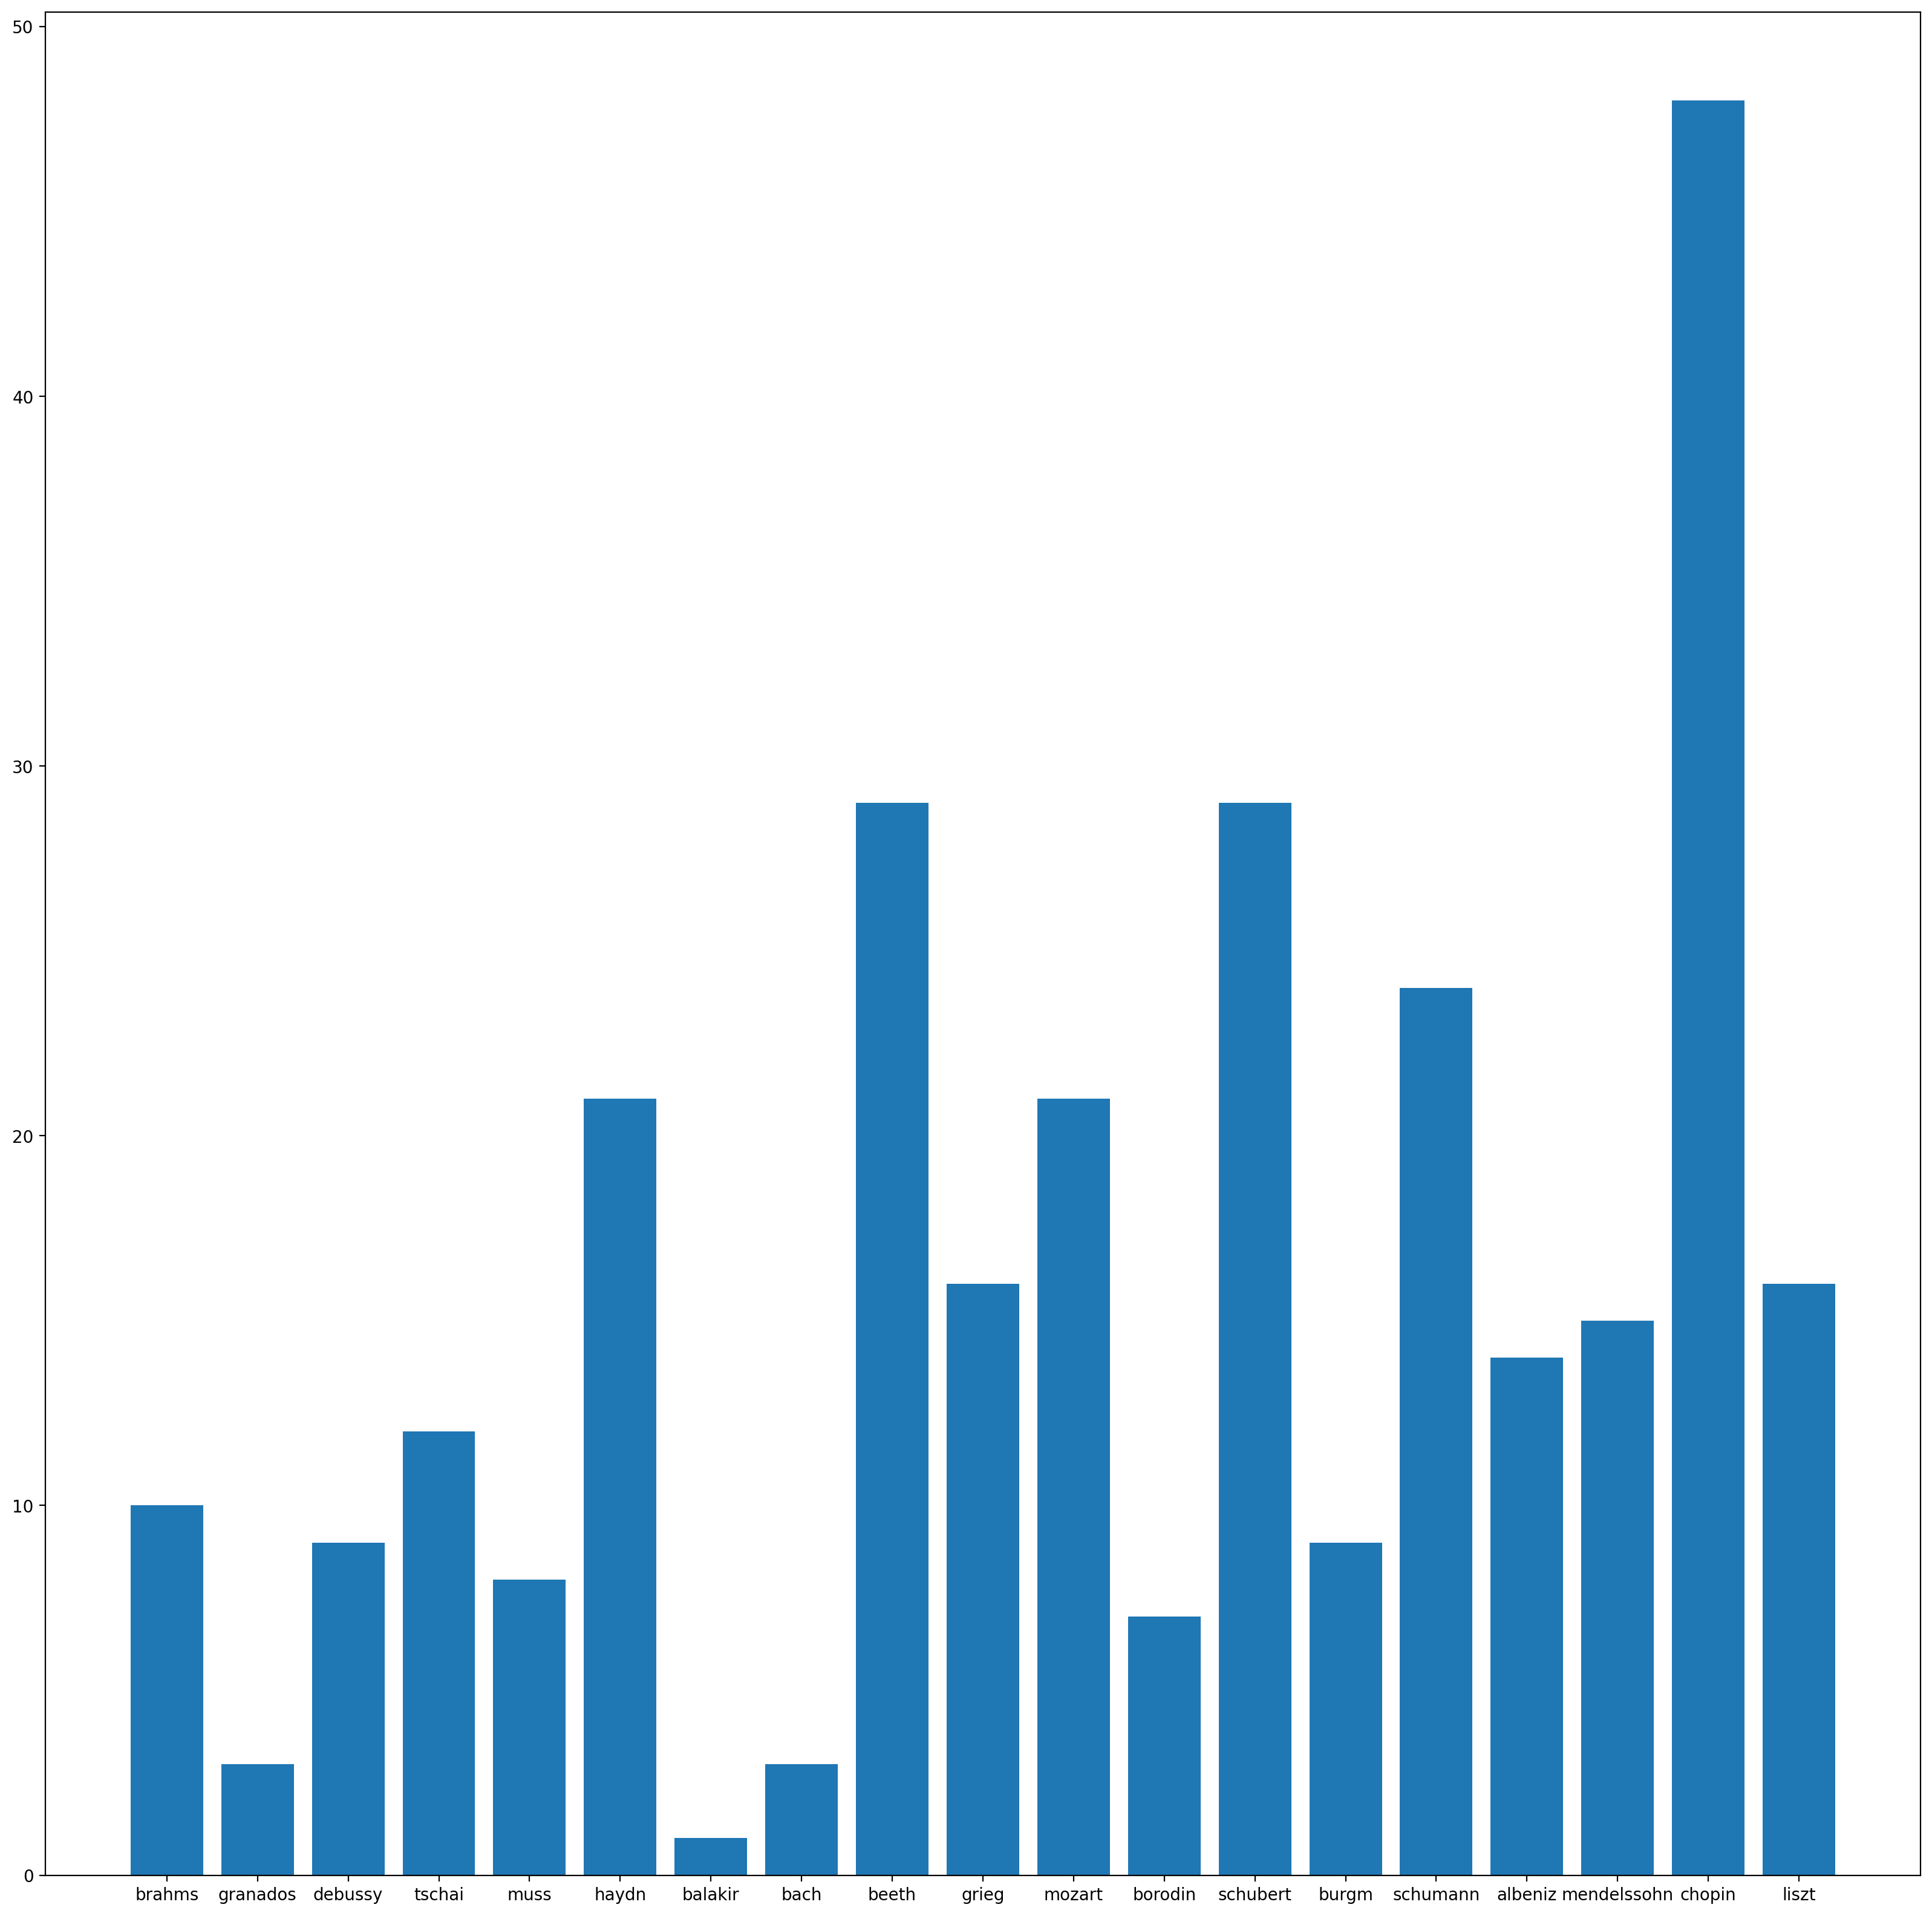

In [5]:
#check for dataset imbalance
from collections import defaultdict
dataset = defaultdict(int)
fig = plt.figure(figsize=(20, 20))
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #the path prefix is 35 chars long
        dataset[dirname[35:]]+=1
keys = dataset.keys()
values = dataset.values()

plt.bar(keys, values)
print(keys)

As we are going to use the musician's music to create new samples, the more data is better. This dataset is skewed towards chopin, which we will use

In [8]:
#Loading the list of chopin's midi files as stream 
filepath = "../input/classical-music-midi/chopin/"
#Getting all chopin midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)


In [10]:
#extract notes from file      
def extract_notes(file):
    notes = []
    pick = None
    counter = 0
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
        counter += 1
    print(len(notes)/counter)
    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

1206.125
Total notes in all the Chopin midis in the dataset: 57894


Data Exploration

We want to see the distribution of notes in bach's work and observe any skew in the data

We want to look at the notes used and chords involved

Note: The musical notes are the building blocks of the music. It pertains to a pitch associated with a specific audio vibration. Western music utilizes twelve musical notes.

Chord: A group of notes that sound good together is a chord.

Explore the Corpus

In [11]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', '6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', '6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', 'F4', 'B4', 'C#2', 'G3', 'B-3', 'G#3', 'G#4', 'B3', 'C#3', '6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', 'C#4', '6.10', 'F#2', 'F3', 'G#3', 'F#3', '6.10', 'B-3', 'C#3', 'C#4', '6.10', 'F#2', 'F3']


Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmptp_z8rq4.ly'
Parsing...
Interpreting music...[8][16][24][32][32]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmptp_z8rq4.ly.eps'...
Converting to PNG...
Deleting `tmptp_z8rq4.ly.eps'...
Layout output to `tmptp_z8rq4.ly-1.eps'...
Layout output to `tmptp_z8rq4.ly-2.eps'...
Layout output to `tmptp_z8rq4.ly-3.eps'...
Layout output to `tmptp_z8rq4.ly-4.eps'...
Layout output to `tmptp_z8rq4.ly-5.eps'...
Writing tmptp_z8rq4.ly-systems.texi...
Writing tmptp_z8rq4.ly-systems.tex...
Writing tmptp_z8rq4.ly-systems.count...
Success: compilation successfully completed


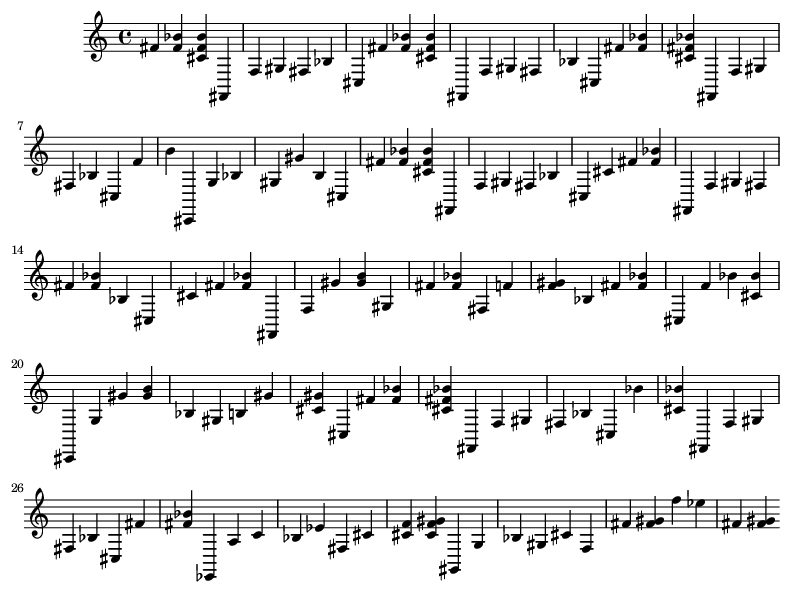

In [12]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
Melody_Snippet.show('midi')
show(Melody_Snippet)

In [13]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


In [14]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print('Most frequent note:', max(count_num, key=count_num.get))
print('Least frequent note:', min(count_num, key=count_num.get))
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Most frequent note: G#3
Least frequent note: 3.4.6.10
Average recurrence for a note in Corpus: 145.8287153652393
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


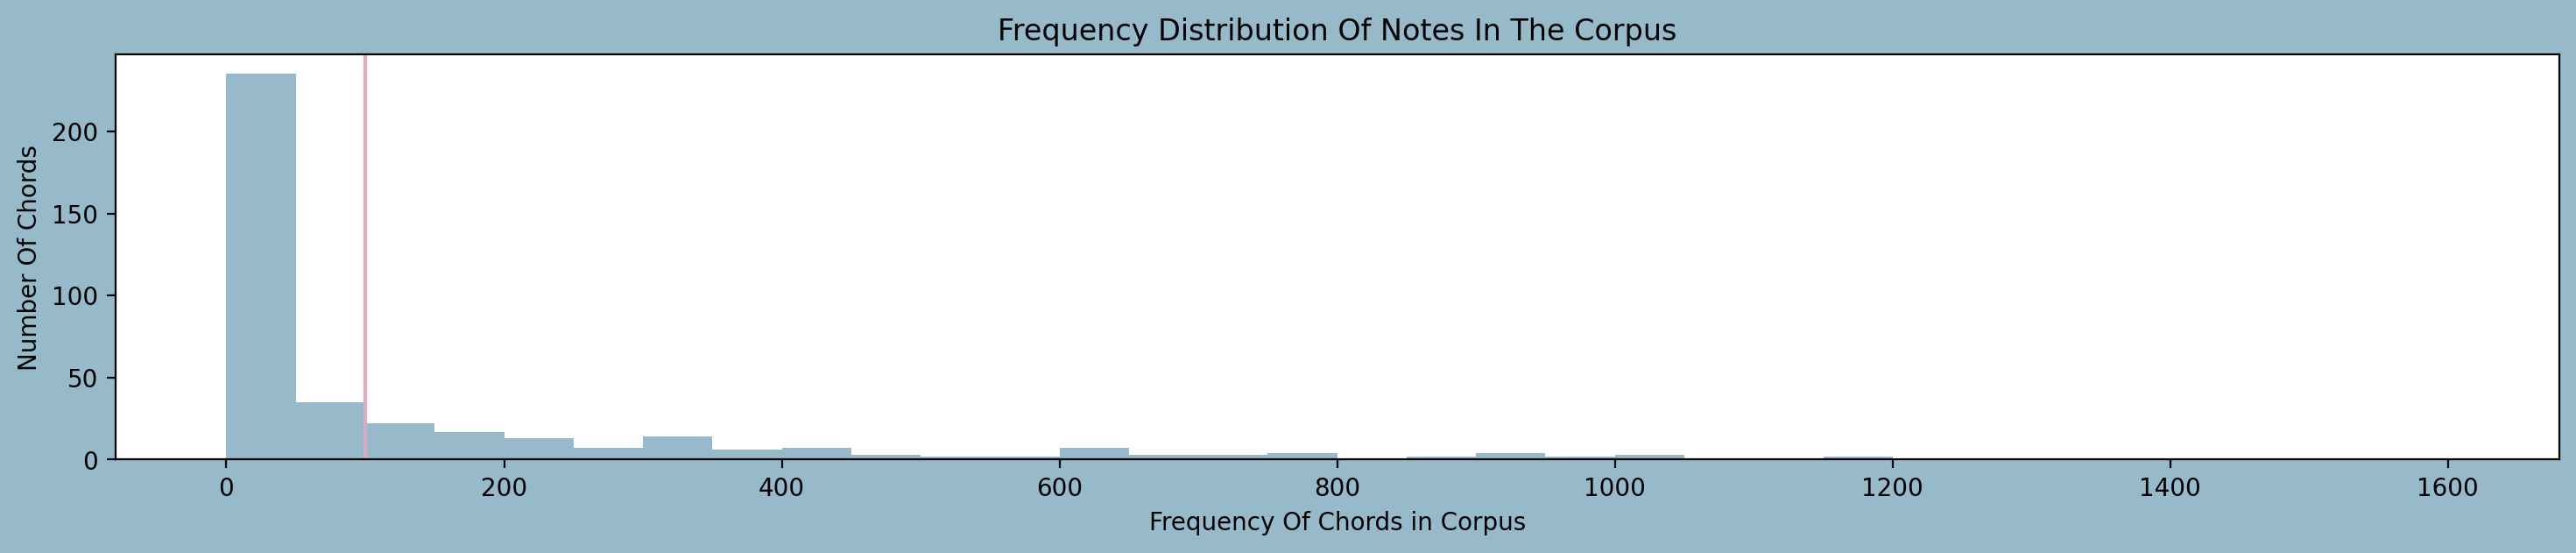

In [15]:
# Plotting the distribution of Notes
#slightly confused between notes and chords
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [16]:
#Getting a list of rare otes
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 270


We eliminate the rarer notes to not include these outliers, which may skew the generation

In [17]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53752


In [18]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53752
Number of unique characters: 263


Start data split and training

Creating a dictionary to map the notes and their indices. We have the note's name as a string the Corpus. For the computer, these names are just a symbol. So we create a dictionary to map each unique note in our Corpus to a number. And vice versa to retrieve the values at the time of prediction. This will be used to encode and decode the information going in and getting out of the LSTM. 

Encoding and splitting the corpus into smaller sequences of equal length: At this point, the Corpus contain notes. We will encode this corpus and create small sequences of equal lengths of features and the corresponding targets. Each feature and target will contain the mapped index in the dictionary of the unique characters they signify. 


In [19]:
#Splitting the Corpus in equal length of strings and output target
#we want to pred the next note
length = 30
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53722


In [20]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [21]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(42977, 30, 1)

LSTM first dimension represents the batch size, the second dimension represents the time-steps and the third dimension represents the number of units in one input sequence

In [ ]:
#Initialising the Model
baseline_model = Sequential()
#Adding layers
baseline_model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
baseline_model.add(LSTM(256))
baseline_model.add(Dense(y.shape[1], activation='softmax'))

#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
baseline_model.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
baseline_model.summary()

In [ ]:

#tensorflow.keras.utils.plot_model(baseline_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:

checkpoint_filepath = '/kaggle/working/checkpoint.model.keras'
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose= True,)

In [ ]:
history = baseline_model.fit(X_train, y_train, batch_size=256, epochs=200, callbacks=[model_checkpoint_callback])

In [ ]:
baseline_model.load_weights(checkpoint_filepath)

In [ ]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [ ]:
def Melody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = baseline_model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        #get pred of note with highest prob
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
#100 notes generated
Music_notes, Melody = Melody_Generator(100)
Melody.show('midi')
show(Melody)

Actual Model Testing

In [ ]:
import keras_tuner

In [ ]:
def build_model(hp):
#Initialising the Model
    model = Sequential()
    #Adding layers
    model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(LSTM(256))
    model.add(Dropout(0.1))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))

    #Compiling the model for training  
    opt = Adamax(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    return model

In [ ]:
tuner = keras_tuner.GridSearch(
    build_model,
    objective='loss',
    max_trials=5)

In [ ]:
tuner.search(X_train, y_train, batch_size=256, epochs=5)
best_model = tuner.get_best_models()[0]
tuner.results_summary()
best_model.summary()

Using GANs

In [ ]:
from keras.layers import Input, Dense, Reshape, Dropout, Bidirectional
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical

Template for simple DCNNGAN

In [ ]:
def get_notes():
    """ Get all the notes and chords from the midi files """
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)
    

    return notes

def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # Reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # Normalize input between -1 and 1
    network_input = (network_input - float(n_vocab)/2) / (float(n_vocab)/2)
    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

def generate_notes(model, network_input, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(network_input)-1)
    
    # Get pitch names and store in a dictionary
    pitchnames = sorted(set(item for item in notes))
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        
        pattern = numpy.append(pattern,index)
        #pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output
  
def create_midi(prediction_output, filename):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for item in prediction_output:
        pattern = item[0]
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))

In [ ]:
def get_notes():
    """ Get all the notes and chords from the midi files """
    notes = Corpus
    return notes

def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # Reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # Normalize input between -1 and 1
    network_input = (network_input - float(n_vocab)/2) / (float(n_vocab)/2)
    network_output = to_categorical(network_output)

    return (network_input, network_output)

def generate_notes(model, network_input, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(network_input)-1)
    
    # Get pitch names and store in a dictionary
    pitchnames = sorted(set(item for item in notes))
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        
        pattern = numpy.append(pattern,index)
        #pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output
  
def create_midi(prediction_output, filename):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for item in prediction_output:
        pattern = item[0]
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))

In [ ]:



class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = 1000
        self.disc_loss = []
        self.gen_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):

        model = Sequential()
        model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
        model.add(Reshape(self.seq_shape))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load and convert the data
        notes = get_notes()
        n_vocab = len(set(notes))
        X_train, y_train = prepare_sequences(notes, n_vocab)
        print(X_train.shape)
        print(y_train.shape)

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Training the model
        for epoch in range(epochs):

            # Training the discriminator
            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]

            #noise = np.random.choice(range(484), (batch_size, self.latent_dim))
            #noise = (noise-242)/242
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new note sequences
            gen_seqs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            #  Training the Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # Print the progress and save into loss lists
            if epoch % sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              self.disc_loss.append(d_loss[0])
              self.gen_loss.append(g_loss)
        
        self.generate(notes)
        self.plot_loss()
        
    def generate(self, input_notes):
        # Get pitch names and store in a dictionary
        notes = input_notes
        pitchnames = sorted(set(item for item in notes))
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        
        # Use random noise to generate sequences
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        predictions = self.generator.predict(noise)
        print(predictions.shape)
        pred_notes = [x*242+242 for x in predictions[0]]
        pred_notes = [int_to_note[int(x)] for x in pred_notes]
        
        create_midi(pred_notes, 'gan_final')
        
    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()

if __name__ == '__main__':
  gan = GAN(rows=100)    
  gan.train(epochs=1, batch_size=32, sample_interval=1)